In [1]:
from functions.functions import *
import functions
import warnings
import torch
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # This is to avoid the memory fragmentation

# Retina display
%config InlineBackend.figure_format = 'retina'


CUDA is available. Using GPU.


In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !curl https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -o dog.jpg


dog.jpg exists


In [9]:
# Loading and preprocessing the image
img_path = "dog.jpg"  # Make sure this path is correct
original_img = load_and_preprocess_image(img_path)
downscaled_img = resize_image(original_img, (200, 200))

In [10]:
# Prepare data for training (200x200)
X_down, Y_down = create_coordinate_map(downscaled_img)
X_down_scaled, scaler = scale_coordinates(X_down)
X_down_rff = create_rff_features(X_down_scaled, 20000, 0.008).to(device)
Y_down = Y_down.to(device)
print(Y_down.min())

tensor(0., device='cuda:0')


In [11]:
X_down, Y_down = create_coordinate_map(downscaled_img)

In [13]:
# Train the model
net = LinearModel(X_down_rff.shape[1], 3).to(device)
train(net, 0.005, X_down_rff.to(device), Y_down.to(device), 2500)

Epoch 0 loss: 0.308667
Epoch 100 loss: 0.039925
Epoch 200 loss: 0.013158
Epoch 300 loss: 0.008067
Epoch 400 loss: 0.005516
Epoch 500 loss: 0.004017
Epoch 600 loss: 0.003091
Epoch 700 loss: 0.002485
Epoch 800 loss: 0.002060
Epoch 900 loss: 0.001742
Epoch 1000 loss: 0.001490
Epoch 1100 loss: 0.001282
Epoch 1200 loss: 0.001107
Epoch 1300 loss: 0.000959
Epoch 1400 loss: 0.000833
Epoch 1500 loss: 0.000727


Epoch 1600 loss: 0.000638
Epoch 1700 loss: 0.000565
Epoch 1800 loss: 0.000504
Epoch 1900 loss: 0.000455
Epoch 2000 loss: 0.000416
Epoch 2100 loss: 0.000385
Epoch 2200 loss: 0.000360
Epoch 2300 loss: 0.000341
Epoch 2400 loss: 0.000327


0.0003156498714815825

In [ ]:
# Prepare data for prediction (400x400)
X_up, Y_up = create_coordinate_map(original_img)
X_up = X_up/2
X_up_scaled = scaler.transform(X_up.cpu())
X_up_scaled = torch.tensor(X_up_scaled).float()
del(X_down_rff); del()
X_up_rff = create_rff_features(X_up_scaled, 20000, 0.008)

In [ ]:
# Predict the upscaled image
predicted_img = predict_image(net, X_up_rff)
predicted_img = rearrange(predicted_img.reshape(400, 400, 3), 'h w c -> c h w')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


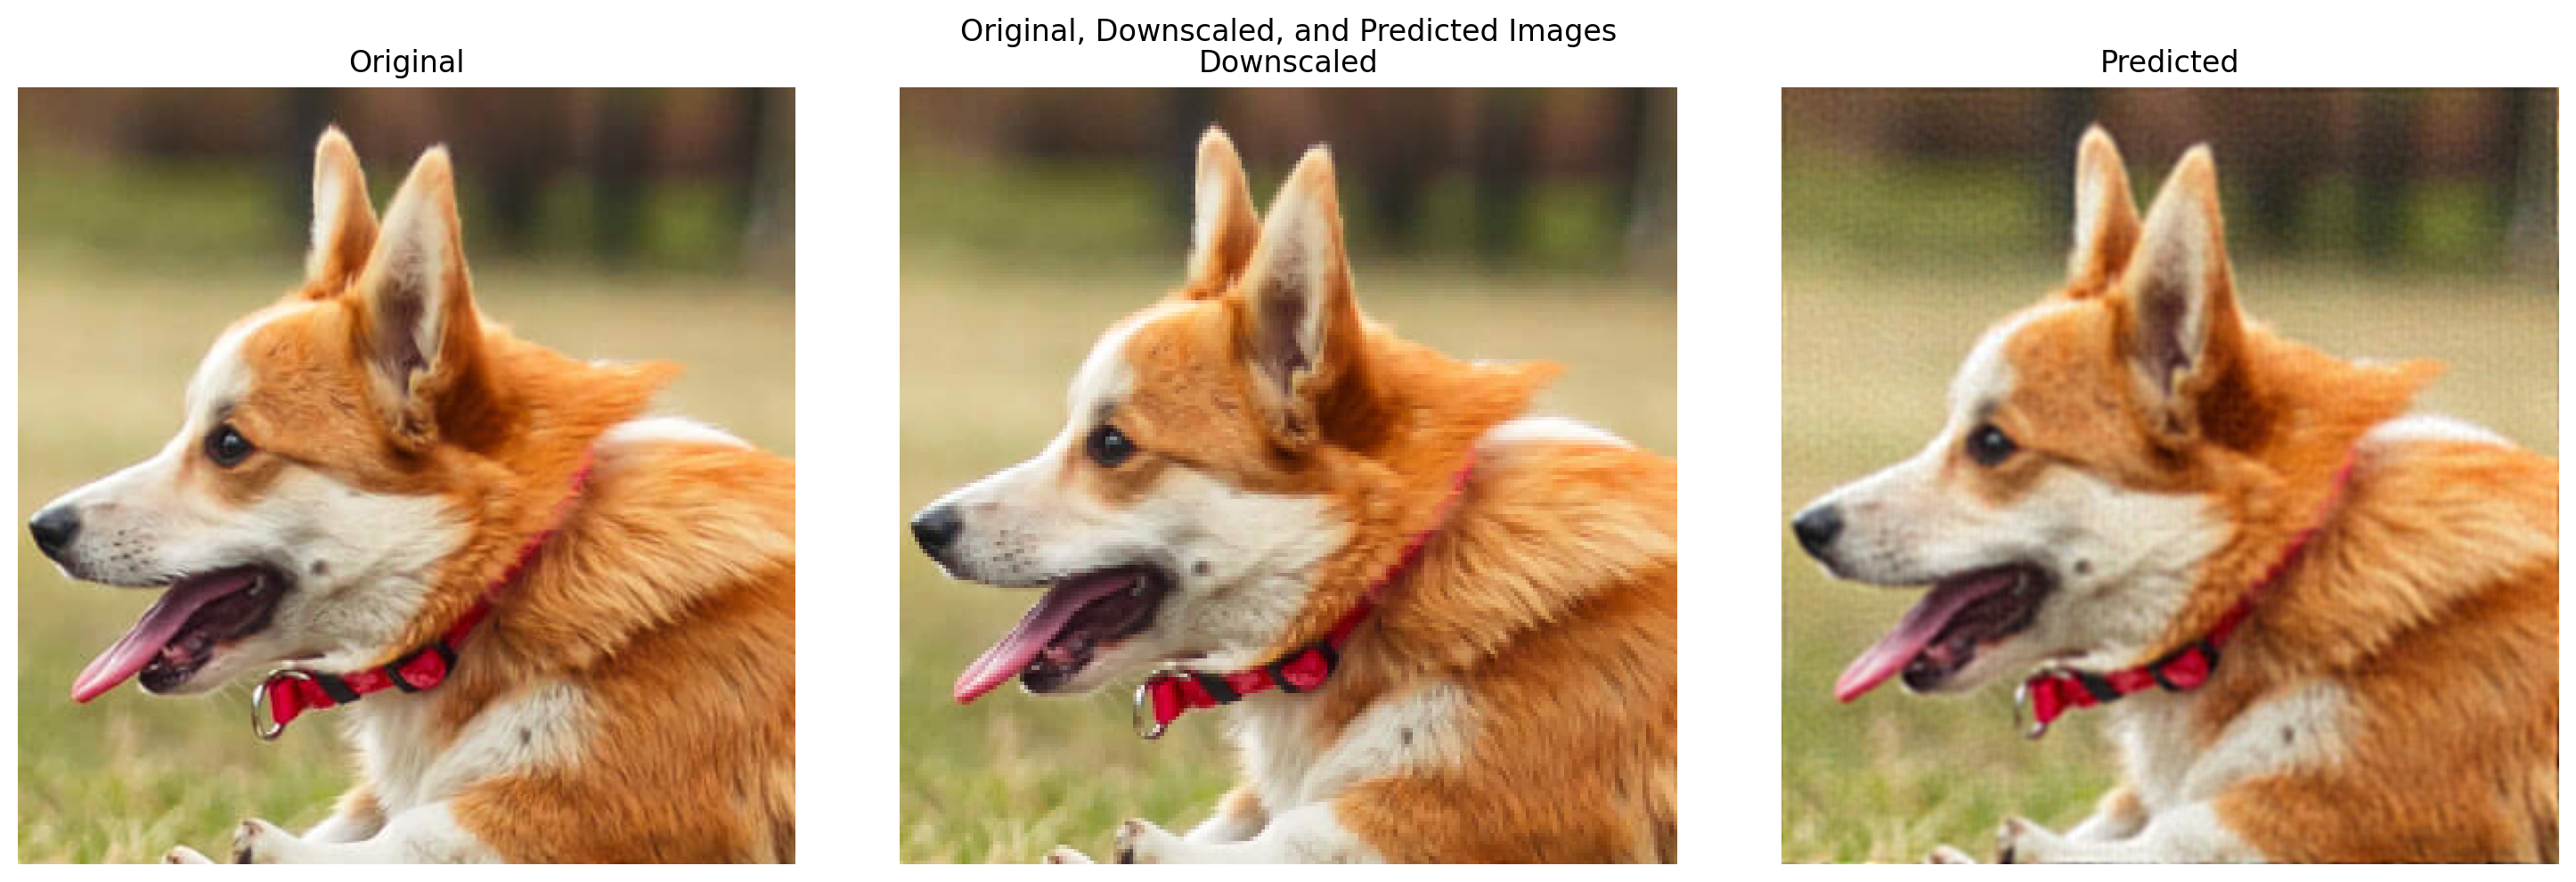

In [ ]:
# Plot the images
plot_images(original_img, downscaled_img, predicted_img, title="Original, Downscaled, and Predicted Images")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


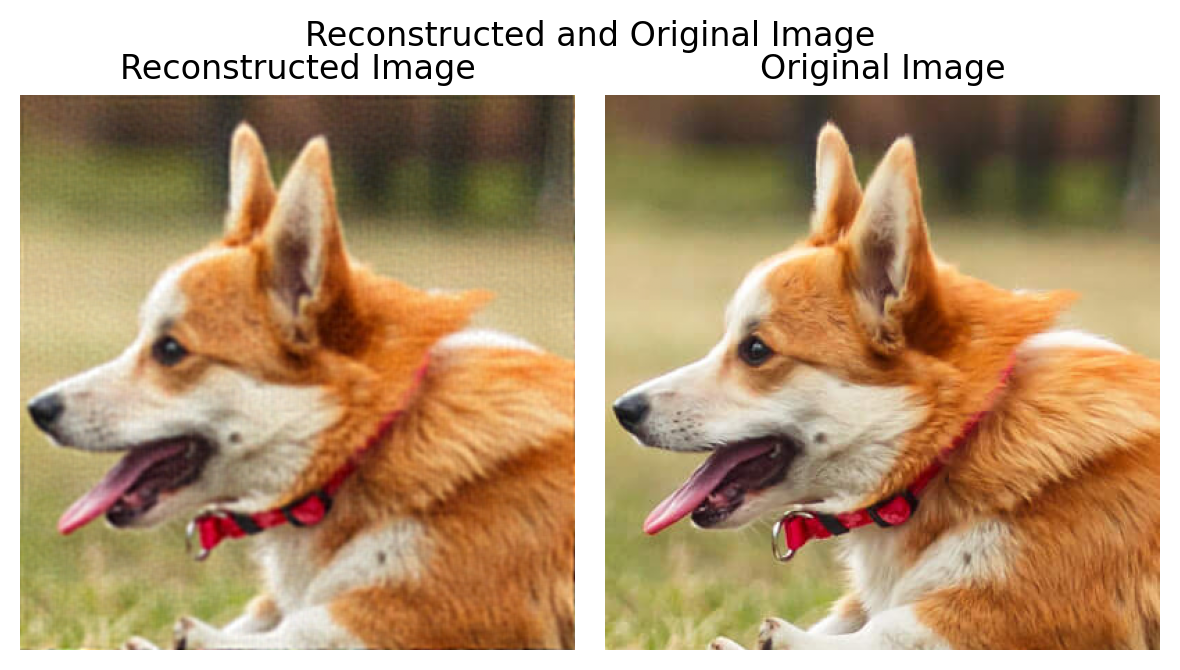

In [ ]:
_ = plot_reconstructed_and_original_image(original_img, net, X_up_rff, title="Reconstructed and Original Image")

In [ ]:
# Calculate metrics
rmse, psnr = calculate_metrics(original_img.to(device), predicted_img.to(device))
print(f"RMSE: {rmse:.4f}")
print(f"PSNR: {psnr:.4f}")

RMSE: 0.0305
PSNR: 30.3099
